# Arc-Eager Parsing
#### Author: Gabriele Sanguin

## Introduction

Transition-based dependency parsing is one of the most popular methods for implementing a dependency parsers. Here we will implement the static **arc-eager** model, as described in the article ["A Dynamic Oracle for Arc-Eager Dependency Parsing"](https://aclanthology.org/C12-1059/) by Yoav Goldberg and Joakim Nivre.  

The notebook will be divided in the following sections:
- Arc-Eager Parsing Description
- Dataset Analysis
- Data set-up
- Baseline model with BiLSTM
- BERT-based model
- Evaluation and Results
- Discussion about SotA in this particular task.

Note that in this work we disregard *arc labels* in dependency trees, to keep the implementations simpler.

In [1]:
!pip install datasets      # huggingface library with dataset
!pip install conllu        # aux library for processing CoNLL-U format
!pip install transformers  # huggingface library with pre-trained models
!pip install evaluate
!pip install accelerate

!pip install wandb         # for comparing results with different hyperparameters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Let's import the packages to be used

In [3]:
import torch
import torch.nn as nn
import numpy as np
from functools import partial
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Let's set the device to `cuda` if `cuda` is available, otherwise `CPU`.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Arc-Eager and static Oracle

## Arc-Eager

A **configuration** of the *Arc-Eager* parser is a triple of the form $( \sigma, \beta, A)$
where:

* $\sigma$ is the stack;
* $\beta$ is the input buffer;
* $A$ is a set of labeled arcs constructed so far, $A ⊆ V_x \times L \times V_x $ where each arc $(i, l, j)$ represents
a dependency with head $w_i$ , dependent $w_j$ , and label $l$

We write $\sigma_i$, $i \geq 1$, for the $i$-th token in the stack; we also write $\beta_i$, $i \geq 1$, for the $i$-th token in the buffer. In particular we use $b$ to indicate the first node of the buffer and we use $s$ for the node on the top of the stack.

The parser can perform four types of **actions** (transitions):

* **left-arc** transition (for any dependency label $l$) adds the arc $(b, l, s)$ to $A$, and pops the stack. It has as a precondition that the token $s$ is not the artificial root node 0 and does not already have a head;
* **right-arc** transition (for any dependency label $l$) adds the arc $(s, l, b)$ to $A$, and pushes the node $b$ onto the stack;
* **reduce** transition pops the stack and is subject to the preconditions that the top token $s$ has a head;
* **shift** transition removes the first node in the buffer and pushes it onto the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.
Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list.
Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.


Let's implement the `ArcEager` class:

In [5]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # one shift move to initialize the stack
    self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    b = self.buffer[0]
    s = self.stack.pop()
    self.arcs[s] = b

  def right_arc(self):
    b = self.buffer[0]
    s = self.stack[-1]
    self.arcs[b] = s
    self.buffer = self.buffer[1:]
    self.stack.append(b)

  def reduce(self):
    s = self.stack.pop()

  def is_tree_final(self):
    return len(self.stack) == 1 and len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

We now do a few manual tests on the parser.  Consider the sentence `He began to write again .` and the associated dependency tree
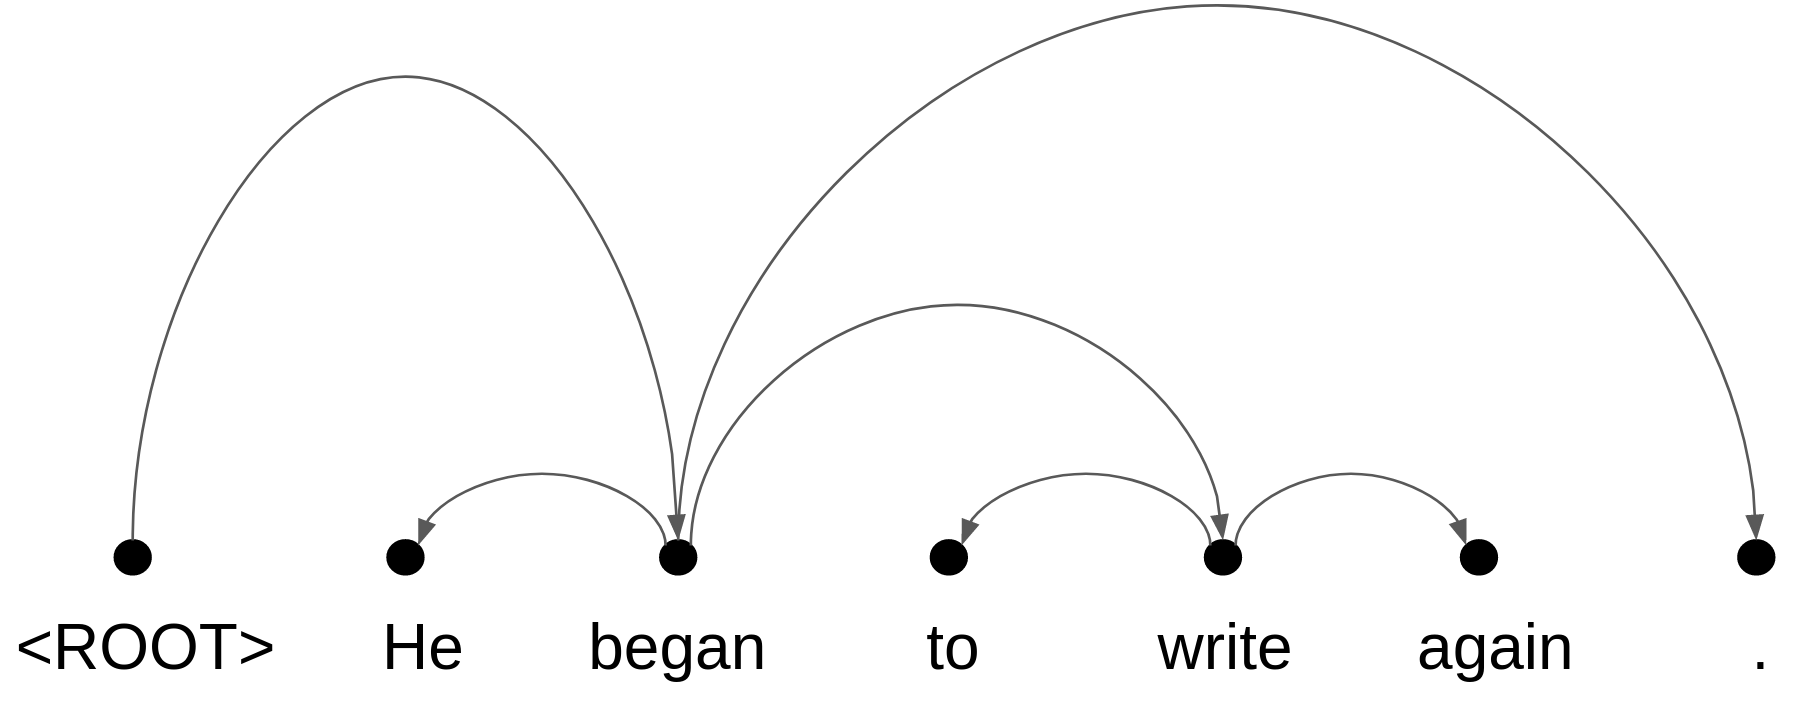

In [6]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
parser.print_configuration()

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [7]:
parser.shift()
parser.print_configuration()

['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [8]:
parser.left_arc()
parser.print_configuration()

['<ROOT>'] ['began', 'to', 'write', 'again', '.']
[-1, 2, -1, -1, -1, -1, -1]


In [9]:
parser.right_arc()
parser.print_configuration()

['<ROOT>', 'began'] ['to', 'write', 'again', '.']
[-1, 2, 0, -1, -1, -1, -1]


Let's also try the reduce transition, even if it is the wrong move

In [10]:
parser.reduce()
parser.print_configuration()

['<ROOT>'] ['to', 'write', 'again', '.']
[-1, 2, 0, -1, -1, -1, -1]


## Oracle

A **static oracle** maps parser configurations $c$ into  actions, and it does so by looking into the gold (reference) tree for the sentence at hand.  If $c$ does not contain any mistake, then the action provided by the oracle for $c$ is guaranted to be correct.  Furthermore, in cases where there is more than one correct action for $c$, the oracle always chooses a single action, called the **canonical** action.

In [11]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    b = self.parser.buffer[0]
    s = self.parser.stack[-1]

    if self.gold[s] == b:
      return True

    return False

  def is_right_arc_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    b = self.parser.buffer[0]
    s = self.parser.stack[-1]

    if self.gold[b] == s:
      return True

    return False

  def is_reduce_gold(self):

    if len(self.parser.buffer) == 0:
      return True

    b = self.parser.buffer[0]
    s = self.parser.stack[-1]

    for i in self.parser.stack:
      if self.gold[s] != -1 and (self.gold[i]==b or self.gold[b]==i):
        return True

    return False

  def is_shift_gold(self):
    if len(self.parser.buffer) == 0:
      return False

    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

Let us come back to our example.

In [12]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

parser.print_configuration()

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


We do a simple manual test on the oracle

In [13]:
print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Reduce:", oracle.is_reduce_gold())
print("Shift: ", oracle.is_shift_gold())

Left Arc:  False
Right Arc:  False
Reduce: False
Shift:  True


In [14]:
parser.shift()
parser.print_configuration()

['<ROOT>', 'He'] ['began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]


In [15]:
print("Left Arc: ", oracle.is_left_arc_gold())
print("Right Arc: ", oracle.is_right_arc_gold())
print("Reduce:", oracle.is_reduce_gold())
print("Shift: ", oracle.is_shift_gold())

Left Arc:  True
Right Arc:  False
Reduce: True
Shift:  False


Then we let the oracle run and we test that it produces the correct gold tree

In [16]:
while not parser.is_tree_final():
  if oracle.is_left_arc_gold():
    parser.left_arc()
  elif oracle.is_right_arc_gold():
    parser.right_arc()
  elif oracle.is_reduce_gold():
    parser.reduce()
  elif oracle.is_shift_gold():
    parser.shift()

print(parser.arcs)
print(gold)

[-1, 2, 0, 4, 2, 4, 2]
[-1, 2, 0, 4, 2, 4, 2]


# Dataset Analysis

We use the huggingface [datasets](https://github.com/huggingface/datasets) library, and train on the English `en_lines` [treebank](https://huggingface.co/datasets/viewer/?dataset=universal_dependencies) from the Universal Dependency project.  



In [18]:
#train_dataset = load_dataset('universal_dependencies', 'fr_gsd', split = 'train')
#dev_dataset = load_dataset('universal_dependencies', 'fr_gsd', split="validation")
#test_dataset = load_dataset('universal_dependencies', 'fr_gsd', split="test")

In [19]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_lines', split="test")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1032 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1035 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


In [20]:
# info about dataset
print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))
print()

sample_sentence = train_dataset[2]
# possible keys
print('Keys:\t', sample_sentence.keys())
print()

# we look into the first sentence in the dataset and print its tokens and (gold) dependency tree
print('Tokens:\t', sample_sentence["tokens"])
print('Head:\t', sample_sentence["head"])
print('Upos:\t', sample_sentence['upos'])

Number of samples:
Train:	 3176
Dev:	 1032
Test:	 1035

Keys:	 dict_keys(['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'])

Tokens:	 ['Some', 'of', 'the', 'content', 'in', 'this', 'topic', 'may', 'not', 'be', 'applicable', 'to', 'some', 'languages', '.']
Head:	 ['11', '4', '4', '1', '7', '7', '4', '11', '11', '11', '0', '14', '14', '11', '11']
Upos:	 [11, 2, 8, 0, 2, 8, 0, 17, 7, 17, 6, 2, 8, 0, 1]


As described in the [documentation](https://universaldependencies.org/treebanks/en_lines/index.html), in this corpus we can find $5243$ sentences and $94217$ tokens.
In particular contains $12250$ tokens (13%) that are not followed by a space and does not contain any words with spaces.
We found $3176$ sentences in the training set, $1032$ in the Validation set and $1035$ to be tested.

The possible keys that describe each sentence are: \
`'idx'`, `'text'`, `'tokens'`, `'lemmas'`, `'upos'`, `'xpos'`, `'feats'`, `'head'`, `'deprel'`, `'deps'`, `'misc'`.

While the possible UPOS tags are numbered from 0 to 17 and they are the following: \
*ADJ, ADP, ADV, AUX, CCONJ, DET, INTJ, NOUN, NUM, PART, PRON, PROPN, PUNCT, SCONJ, SYM, VERB, X*




The key `head` selects an array representing the gold dependency tree for the sentence at hand, in the format discussed above.

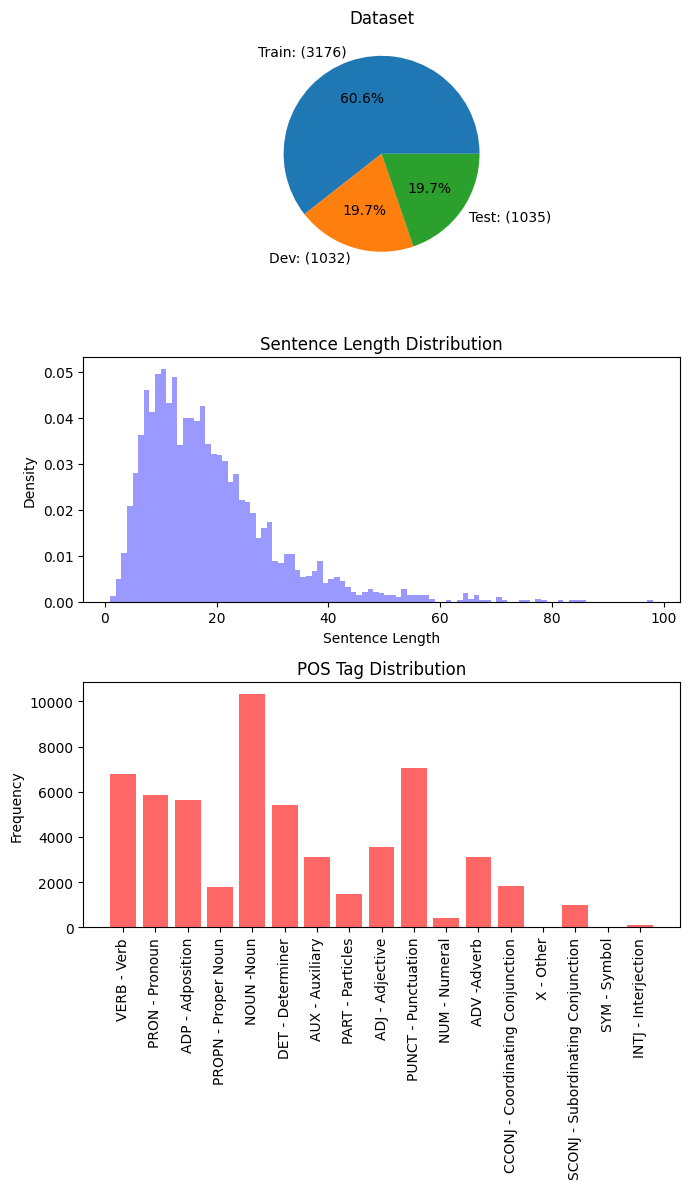

In [21]:
# 3 plots in column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 12))

# Pie chart for dataset splitting
dataset = ['Train', 'Dev', 'Test']
lengths = [len(train_dataset), len(dev_dataset), len(test_dataset)]

pie_labels = [f"{label}: ({length})" for label, length in zip(dataset, lengths)]
ax1.pie(lengths, labels=pie_labels, autopct='%1.1f%%')
ax1.set_title('Dataset')

# Sentence lenght distribution in train_dataset
sentences_length = [len(sentence) for sentence in train_dataset['tokens']]
ax2.hist(sentences_length, bins=range(min(sentences_length), max(sentences_length) + 1, 1),
         alpha=0.4, color="blue", density=True, stacked=True)
ax2.set_xlabel("Sentence Length")
ax2.set_ylabel("Density")
ax2.set_title("Sentence Length Distribution")

# Pos tag distribution in train_dataset
pos_counts = {}

pos_marks = ['0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9',
    '10',
    '11',
    '12',
    '14',
    '15',
    '16',
    '17']

pos_map = {
    0: 'NOUN -Noun',
    1: 'PUNCT - Punctuation',
    2: 'ADP - Adposition',
    3: 'NUM - Numeral',
    4: 'SYM - Symbol',
    5: 'SCONJ - Subordinating Conjunction',
    6: 'ADJ - Adjective',
    7: 'PART - Particles',
    8: 'DET - Determiner',
    9: 'CCONJ - Coordinating Conjunction',
    10: 'PROPN - Proper Noun',
    11: 'PRON - Pronoun',
    12: 'X - Other',
    14: 'ADV -Adverb',
    15: 'INTJ - Interjection',
    16: 'VERB - Verb',
    17: 'AUX - Auxiliary',
}


for s in train_dataset:
    for i, token in enumerate(s["tokens"]):
        pos_tag = s['upos'][i]
        if pos_tag in pos_counts:
            pos_counts[pos_tag] += 1
        else:
            pos_counts[pos_tag] = 1

pos_tags, counts = zip(*pos_counts.items())
pos_names = [pos_map.get(pos_tag) for pos_tag in pos_tags]

ax3.bar(pos_marks, counts, alpha = 0.6, color='red')
#ax3.set_xlabel('POS Tags')
ax3.set_ylabel('Frequency')
ax3.set_xticks(np.arange(17))
ax3.set_xticklabels(pos_names, rotation=90)
ax3.set_title('POS Tag Distribution')

plt.tight_layout()
plt.show()

# Data set-up



To run the arc-eager parser we need a classifier that looks at some of the content of the current parser configuration and selects an approapriate action.  In order to train the classifier, we need to convert the gold trees in our treebank into several pairs of the form configuration/gold action.

More over we are going to use a BERT-tokenizer that assigns embeddings to each token using BPE and words may be split into several tokens. We need to take care of this by keeping track of which word each token belongs to.

Let's start with an overview of how our BERT-tokenizer works. We use the pre-trained model `"bert-base-multilingual-uncased"`.

In [22]:
model_name = "bert-base-multilingual-uncased"

# We use a fast tokenizer in order to get access to `word_ids`
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)

In [23]:
encoded_input = tokenizer(sample_sentence['tokens'], is_split_into_words = True, padding='max_length', max_length=120, truncation=True, return_tensors = 'pt')

print('Original tokens:\t', sample_sentence['tokens'])
print('Encoded input ids:\t', encoded_input['input_ids'][0][:15])
print('Token type ids:\t', encoded_input['token_type_ids'][0][:15])
print('Attention_mask:\t', encoded_input['attention_mask'][0][:15])

tokens_encoded_input = tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])
word_ids_encoded_input = encoded_input.word_ids()

print('Encoded input tokens:\t', tokens_encoded_input[:20])
print('Word ids:\t', word_ids_encoded_input[:15])

Original tokens:	 ['Some', 'of', 'the', 'content', 'in', 'this', 'topic', 'may', 'not', 'be', 'applicable', 'to', 'some', 'languages', '.']
Encoded input ids:	 tensor([  101, 10970, 10108, 10103, 18491, 10104, 10372, 47620, 10431, 10497,
        10346, 35821, 95306, 10114, 10970])
Token type ids:	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Attention_mask:	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Encoded input tokens:	 ['[CLS]', 'some', 'of', 'the', 'content', 'in', 'this', 'topic', 'may', 'not', 'be', 'app', '##licable', 'to', 'some', 'languages', '.', '[SEP]', '[PAD]', '[PAD]']
Word ids:	 [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12]


Each sentence after been *tokenize* get the keys: `input_ids`, `type_ids`, `attention_mask`.
More over, by using a **fast tokenizer** we could find the attribute `word_ids` that for each token return the index of the corrispondent word.


We are now ready to proceed with the **pre-process of the training set**:
- We implement  a funtion to add the `<ROOT>` token at the beginning of the samples and `-1` to the **head**;
- We proceed with the tokenization with a Bert Tokenizer in order to save in each sample his `input_ids` and `word_ids` to keep track of the correspondence "token-word";
- We remove non-projective trees from the training set;
- We create a dictionary of word/index pairs, to be used later when creating word embeddings.  Words that have less than three occurrences are not encoded and will later be mapped to special token `<unk>`.

In [24]:
def add_tokenization(sample):
  sample['tokens'].insert(0, '<ROOT>')
  sample['head'].insert(0, '-1')

  tokenized_sample = tokenizer(sample['tokens'], is_split_into_words = True, padding='max_length', max_length=120, truncation=True, return_tensors = 'pt')
  sample['input_ids'] = tokenized_sample['input_ids'][0]
  sample['word_ids'] = tokenized_sample.word_ids()

  return sample

# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<unk>"] = 1 #used for words that do not appear in our list

  next_indx = 2
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

In [25]:
# perform add_tokenization() to all datasets
train_dataset = train_dataset.map(add_tokenization)
dev_dataset = dev_dataset.map(add_tokenization)
test_dataset = test_dataset.map(add_tokenization)

# remove sentences without clear head (needed for some dataset different from 'en_lines')
train_dataset = [sample for sample in train_dataset if 'None' not in sample['head'] ]
dev_dataset =  [sample for sample in dev_dataset if 'None' not in sample['head'] ]
test_dataset =  [sample for sample in test_dataset if 'None' not in sample['head'] ]

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if is_projective([int(head) for head in sample["head"]])]

# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Map:   0%|          | 0/3176 [00:00<?, ? examples/s]

Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


The next function is used to process our data and create the actual training samples.

For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.  We then pair configurations and canonical actions.  

We could let our neural classifier look only into $\sigma_1$ and $\beta_1$ since the parser works with only these elements when performing the transitions. In this way we do not have to record the full parser configuration. As an implementation, we let our classifiers to look also to $\sigma_2$, that is proved to give better perfomance.

In particular, for the implementation with the Bert-based model we will also need to return the tokenization's information previously stored.



In [26]:
def process_sample(sample, get_gold_path = False):

  # put sentence and gold tree in our format
  sentence = sample["tokens"]
  gold = [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary
                  else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      # (we can implement configurations with 2 toppest elements of stack
      # and first element of buffer in order to have better performances)
      if len(parser.stack) == 1:
        conf = [-1, parser.stack[-1], parser.buffer[0]]
      elif len(parser.buffer) == 0:
        conf = [parser.stack[-2], parser.stack[-1], -1]
      else:
        conf = [parser.stack[-2], parser.stack[-1], parser.buffer[0]]

      gold_path.append(conf)

      # save gold move
      if oracle.is_left_arc_gold():
        parser.left_arc()
        gold_moves.append(0)
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  # returning also 'input_ids' and 'word_ids' that are used in a
  # pre-trained tokenizer like Bert
  return enc_sentence, gold_path, gold_moves, gold, sample['input_ids'], sample['word_ids']

Next function used to batch the training data.

In [27]:
def prepare_batch(batch_data, get_gold_path=False ):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees, input_ids and word_ids are parallel arrays,
  # each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  input_ids = [s[4] for s in data]
  word_ids = [s[5] for s in data]

  return  sentences, paths, moves, trees, input_ids, word_ids



Finally, we create dataloaders for train, validation and test sets.

In [28]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

# Baseline model with Bi-LSTM  

As first task we build a model that exploits the Bi_LSTM ability to study and explore embedded input sentences. It effectively captures the contextual information from both past and future words in the sequence, therefore it can adeguately rappresent words togheter with their context.  

After obtaining these first contextual information, we'll pass them to a feed forward network to predict the next move of the parser. We use a **multi layer perceptron** (mlp) to generate a vector of dimension 4 rapresenting the probabilities (or scores) of each possible transition of the parser.

Finally, when `infere()` is called, we perfom the transition with the highest score, always if preconditions are satisfied.


Let's start by setting up some hyperparmeters and defining the class.


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ArcEager_parser_BiLSTM_and_BERT",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "Bi-LSTM",
    "epochs": 15,
    "DROPOUT" : 0.2,
    "act_function": "LeakyReLU"
    }
)

config = wandb.config

wandb: Currently logged in as: gabriele-sanguin (gibrisan). Use `wandb login --relogin` to force relogin


In [ ]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = config.DROPOUT
EPOCHS = config.epochs
LR = config.learning_rate

In [ ]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.LeakyReLU()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i],
                                    zero_tensor if j[1]==-1 else h[j[1]][i],
                                    zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      elif len(parser.stack) == 1:
        conf = [-1, parser.stack[-1], parser.buffer[0]]
      elif len(parser.buffer) == 0:
        conf = [parser.stack[-2], parser.stack[-1], -1]
      else:
        conf = [parser.stack[-2], parser.stack[-1], parser.buffer[0]]
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):

    moves_argm = moves.argmax(-1) # array of lenght len(batch)

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue

      else:

        # useful variable and boolean conditions:
        s = parsers[i].stack[-1] # top element of the stack
        only_root = bool(s == 0) # True if only root on stack
        empty_buffer = bool(len(parsers[i].buffer) == 0) # True if the buffer is empty
        with_head = bool(parsers[i].arcs[s] != -1) # True if s has already an head
        sorted_moves = sorted(range(4), key=lambda k: moves[i][k]) # vector with moves indeces sorted

        # left-arc
        if moves_argm[i] == 0:

          if not empty_buffer and not only_root and not with_head:
            parsers[i].left_arc()

          else:
            if empty_buffer:
              parsers[i].reduce()
            else:
              if sorted_moves[-2] == 1:
                parsers[i].right_arc()
              elif sorted_moves[-2]  == 2 and not only_root:
                parsers[i].reduce()
              else:
                parsers[i].shift()

        #right-arc
        elif moves_argm[i] == 1:
          if not empty_buffer:
            parsers[i].right_arc()
          else:
            parsers[i].reduce()

        # reduce
        elif moves_argm[i] == 2:
          if not only_root and with_head:
            parsers[i].reduce()

          else:

            if not with_head and not empty_buffer:
              if sorted_moves[-2] == 0 and not only_root:
                parsers[i].left_arc()
              elif sorted_moves[-2] == 1:
                parsers[i].right_arc()
              else:
                parsers[i].shift()

            else:
              if not empty_buffer:
                if sorted_moves[-2] == 1:
                  parsers[i].right_arc()
                else:
                  parsers[i].shift()
              else:
                parsers[i].reduce()

        # shift
        elif moves_argm[i] == 3:
          if not empty_buffer:
            parsers[i].shift()
          else:
            parsers[i].reduce()



##Train and Test
Now that we have defined all our components, we are ready to train and test our model.

First we define our evaluation function. We use UAS (Unlabeled Accuracy Score) which is the percentage of correct arcs predicted over all the arcs.

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

Next, we define our train loop and the test function to run inference.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    sentences, paths, moves, trees, input_ids, word_ids = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device)
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees, input_ids, word_ids = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

Finally, we run the training of our neural dependency parser.

In [ ]:
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Epoch:   0 | avg_train_loss: 1.045 | dev_uas: 0.573 |
Epoch:   1 | avg_train_loss: 0.920 | dev_uas: 0.613 |
Epoch:   2 | avg_train_loss: 0.890 | dev_uas: 0.634 |
Epoch:   3 | avg_train_loss: 0.871 | dev_uas: 0.662 |
Epoch:   4 | avg_train_loss: 0.857 | dev_uas: 0.683 |
Epoch:   5 | avg_train_loss: 0.848 | dev_uas: 0.691 |
Epoch:   6 | avg_train_loss: 0.838 | dev_uas: 0.707 |
Epoch:   7 | avg_train_loss: 0.830 | dev_uas: 0.720 |
Epoch:   8 | avg_train_loss: 0.824 | dev_uas: 0.717 |
Epoch:   9 | avg_train_loss: 0.819 | dev_uas: 0.722 |
Epoch:  10 | avg_train_loss: 0.813 | dev_uas: 0.731 |
Epoch:  11 | avg_train_loss: 0.808 | dev_uas: 0.728 |
Epoch:  12 | avg_train_loss: 0.805 | dev_uas: 0.738 |
Epoch:  13 | avg_train_loss: 0.802 | dev_uas: 0.735 |
Epoch:  14 | avg_train_loss: 0.798 | dev_uas: 0.744 |


And we test on the test set.

In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

wandb.log({"test_uas": test_uas})

test_uas: 0.746


In [ ]:
wandb.finish()

# BERT-based Model

As said before the Bert-based model we are going to use is `'bert-base-multilingual-uncased'`.
It is pretrained model on the top 102 languages with the largest Wikipedia using a masked language modeling (MLM) objective. This model is uncased: it does not make a difference between english and English.

In [29]:
BERT_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
print(BERT_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(105879, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

We can observe that it uses a *vocabolary* of $105879$ words and *word embeddings* of size $768$. It is build with 12 encoding layer + one pooler layer.

Let's see how it works:

In [31]:
sample_sentence = train_dataset[2]

print('Original text:\t', sample_sentence['tokens'])

encoded_input = tokenizer(sample_sentence['tokens'], is_split_into_words = True, padding='max_length', max_length=120, truncation=True, return_tensors = 'pt')
output = BERT_model(**encoded_input)

print('Tokenized text:\t', tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])[:25])
print()
print('Tokenized input ids:\t', encoded_input['input_ids'][0,:25])
print()
print('Bert model embeddings shape:', output.last_hidden_state.shape)

Original text:	 ['<ROOT>', 'Some', 'of', 'the', 'content', 'in', 'this', 'topic', 'may', 'not', 'be', 'applicable', 'to', 'some', 'languages', '.']
Tokenized text:	 ['[CLS]', '<', 'root', '>', 'some', 'of', 'the', 'content', 'in', 'this', 'topic', 'may', 'not', 'be', 'app', '##licable', 'to', 'some', 'languages', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

Tokenized input ids:	 tensor([  101,   133, 33765,   135, 10970, 10108, 10103, 18491, 10104, 10372,
        47620, 10431, 10497, 10346, 35821, 95306, 10114, 10970, 18240,   119,
          102,     0,     0,     0,     0])

Bert model embeddings shape: torch.Size([1, 120, 768])


In the code below we can now implement a BERT-based parser, that uses the contextualized embeddings by calling the model on the `input_ids` previously stored. We are taking the sum of the outputs of the last 4 hidden layer for a better performance.

As we can see from the above example, unknown words are split into subtokens: we will use `word_ids` in order to have a single embedding for each word by taking the mean of the embeddings of his subtokens.
Once word embeddings is fixed we can proceed in the same way as we did in the Bi-LSTM model.

We train our parser and perform fine-tuning on the BERT-model. In particular we will freeze the first 7 layer in order to perform fine-tuning only in the last ones. More over

In [32]:
wandb.init(
    project="ArcEager_parser_BiLSTM_and_BERT",

    config={
    "learning_rate": 0.001,
    "architecture": "BERT",
    "epochs": 15,
    "DROPOUT" : 0.2,
    "act_function": "LeakyReLU"
    })

config = wandb.config

wandb: Currently logged in as: gabriele-sanguin (gibrisan). Use `wandb login --relogin` to force relogin


In [33]:
#Parameters
EMB_SIZE = 768
MLP_SIZE = 200
DROPOUT = config.DROPOUT
EPOCHS = config.epochs
LR = config.learning_rate


In [35]:
class Bert_Net(nn.Module):

  def __init__(self, device):
    super(Bert_Net, self).__init__()
    self.device = device

    BERT_model.to(self.device)

    # Freeze the first 8 layers
    for param in BERT_model.encoder.layer[:8].parameters():
            param.requires_grad = False

    # initialize feedforward
    self.w1 = torch.nn.Linear(3*EMB_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.LeakyReLU()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, input_ids, paths, word_ids):

    # run bert encoder
    h = self.bert_pass(input_ids)

    # for each parser configuration that we need to score we arrange from the
    # output of bert encoder the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h, word_ids).to(self.device)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input).to(self.device)

    return out

  def bert_pass(self, input_ids):

    input_ids = torch.tensor(input_ids).to(self.device) # inputs to device
    h = BERT_model(input_ids.to(self.device), output_hidden_states = True) # return list of outputs of each layer
    h = torch.sum(torch.stack([h.hidden_states[-1-i] for i in range(4)]), dim = 0).to(self.device) # we sum the outputs of last 4 layers
    return h # shape = (batch_size, 120, 768)

  def get_mlp_input(self, configurations, h, word_ids):
    mlp_input = []
    zero_tensor = torch.zeros(EMB_SIZE, requires_grad=False).to(self.device)

    for i in range(len(configurations)): # for every sentence in the batch
      word_ids_i = np.array(word_ids[i]) # we take the word_ids of sentence i

      for j in configurations[i]: # for each configuration of a sentence

        # words may be split in several tokens so we take them all
        tokens_j0 = np.where(word_ids_i == j[0])[0]
        tokens_j1 = np.where(word_ids_i == j[1])[0]
        tokens_j2 = np.where(word_ids_i == j[2])[0]

        # we take as input the mean of the embeddings of the tokens of word in
        # configurations if exist, a zero vector otherwise
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else torch.mean(h[i][tokens_j0], dim=0),
                                    zero_tensor if j[1]==-1 else torch.mean(h[i][tokens_j1], dim=0),
                                    zero_tensor if j[2]==-1 else torch.mean(h[i][tokens_j2], dim=0)]))

    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, sentences, input_ids, word_ids):

    parsers = [ArcEager(i) for i in sentences]

    h = self.bert_pass(input_ids)

    # keep track of the transitions
    pred_moves = [[] for _ in range(len(parsers))]

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, word_ids).to(self.device)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step

      pred_moves = self.parse_step(parsers, mlp_out, pred_moves)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers], pred_moves

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      elif len(parser.stack) == 1:
        conf = [-1, parser.stack[-1], parser.buffer[0]]
      elif len(parser.buffer) == 0:
        conf = [parser.stack[-2], parser.stack[-1], -1]
      else:
        conf = [parser.stack[-2], parser.stack[-1], parser.buffer[0]]
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # We select and perform the next move according to the scores obtained
  def parse_step(self, parsers, moves, pred_moves):

    moves_argm = moves.argmax(-1) # array of lenght len(batch)

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue

      else:

        # useful variable and boolean conditions:
        s = parsers[i].stack[-1] # top element of the stack
        only_root = bool(s == 0) # True if only root on stack
        empty_buffer = bool(len(parsers[i].buffer) == 0) # True if the buffer is empty
        with_head = bool(parsers[i].arcs[s] != -1) # True if s has already an head
        sorted_moves = sorted(range(4), key=lambda k: moves[i][k]) # vector with moves indeces sorted

        # left-arc
        if moves_argm[i] == 0:

          if not empty_buffer and not only_root and not with_head:
            parsers[i].left_arc()
            pred_moves[i].append(0)

          else:
            if empty_buffer:
              parsers[i].reduce()
              pred_moves[i].append(2)
            else:
              if sorted_moves[-2] == 1:
                parsers[i].right_arc()
                pred_moves[i].append(1)
              elif sorted_moves[-2]  == 2 and not only_root:
                parsers[i].reduce()
                pred_moves[i].append(2)
              else:
                parsers[i].shift()
                pred_moves[i].append(3)

        #right-arc
        elif moves_argm[i] == 1:
          if not empty_buffer:
            parsers[i].right_arc()
            pred_moves[i].append(1)
          else:
            parsers[i].reduce()
            pred_moves[i].append(2)

        # reduce
        elif moves_argm[i] == 2:
          if not only_root and with_head:
            parsers[i].reduce()
            pred_moves[i].append(2)

          else:

            if not with_head and not empty_buffer:
              if sorted_moves[-2] == 0 and not only_root:
                parsers[i].left_arc()
                pred_moves[i].append(0)
              elif sorted_moves[-2] == 1:
                parsers[i].right_arc()
                pred_moves[i].append(1)
              else:
                parsers[i].shift()
                pred_moves[i].append(3)

            else:
              if not empty_buffer:
                if sorted_moves[-2] == 1:
                  parsers[i].right_arc()
                  pred_moves[i].append(1)
                else:
                  parsers[i].shift()
                  pred_moves[i].append(3)
              else:
                parsers[i].reduce()
                pred_moves[i].append(2)

        # shift
        elif moves_argm[i] == 3:
          if not empty_buffer:
            parsers[i].shift()
            pred_moves[i].append(3)
          else:
            parsers[i].reduce()
            pred_moves[i].append(2)

    return pred_moves


## Train and Test
Now that we have defined all our components, we are ready to train and test our model.

First we define our evaluation function for Bert-based model. We use UAS (Unlabeled Accuracy Score) as we did before.

In [36]:
def evaluate(gold, preds):
  total = 0
  correct = 0
  wrong_non_proj = 0 # for non-projective trees labeled wrongly
  non_proj = 0  # total non-projective trees
  wrong_ind = []

  for n, gold, preds in zip((range(len(gold))),gold,preds):

    found_non_proj = False
    found_wrong = False
    already_checked = False

    if not is_projective(gold):
      found_non_proj = True
      non_proj += 1

    for i in range(1,len(gold)):
      total += 1

      if gold[i] == preds[i]:
        correct += 1

      else:
        if not already_checked:
          found_wrong = True
          wrong_ind.append(n)

          if found_non_proj:
              wrong_non_proj +=1

          already_checked = True

  return correct/total, wrong_non_proj, non_proj, wrong_ind


Next, we define our train loop and the test function to run inference.

In [37]:
def Bert_train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:

    optimizer.zero_grad()
    sentences, paths, moves, trees, input_ids, word_ids = batch

    out = model(input_ids, paths, word_ids)
    labels = torch.tensor(sum(moves, [])).to(device)
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def Bert_test(model, dataloader):
  model.eval()

  gold = []
  preds = []
  pred_moves_BERT = [[] for _ in range(len(dataloader))]

  for i,batch in enumerate(dataloader):

    sentences, paths, moves, trees, input_ids, word_ids = batch

    with torch.no_grad():
      pred, pred_moves = model.infere(sentences, input_ids, word_ids)

      pred_moves_BERT[i] = pred_moves
      gold += trees
      preds += pred

  return evaluate(gold, preds), pred_moves_BERT

Finally, we run the training of our Bert-based parser.

In [38]:
model = Bert_Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = Bert_train(model, train_dataloader, criterion, optimizer)
  (val_uas, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT = Bert_test(model, dev_dataloader)

  wandb.log({"avg_train_loss": avg_train_loss, "val_uas": val_uas})

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Epoch:   0 | avg_train_loss: 0.940 | dev_uas: 0.739 |
Epoch:   1 | avg_train_loss: 0.855 | dev_uas: 0.760 |
Epoch:   2 | avg_train_loss: 0.840 | dev_uas: 0.785 |
Epoch:   3 | avg_train_loss: 0.832 | dev_uas: 0.807 |
Epoch:   4 | avg_train_loss: 0.825 | dev_uas: 0.799 |
Epoch:   5 | avg_train_loss: 0.819 | dev_uas: 0.813 |
Epoch:   6 | avg_train_loss: 0.816 | dev_uas: 0.821 |
Epoch:   7 | avg_train_loss: 0.812 | dev_uas: 0.824 |
Epoch:   8 | avg_train_loss: 0.809 | dev_uas: 0.830 |
Epoch:   9 | avg_train_loss: 0.805 | dev_uas: 0.828 |
Epoch:  10 | avg_train_loss: 0.803 | dev_uas: 0.834 |
Epoch:  11 | avg_train_loss: 0.800 | dev_uas: 0.828 |
Epoch:  12 | avg_train_loss: 0.800 | dev_uas: 0.833 |
Epoch:  13 | avg_train_loss: 0.798 | dev_uas: 0.836 |
Epoch:  14 | avg_train_loss: 0.797 | dev_uas: 0.841 |


And we test on the test set.

In [39]:
(test_uas, wrong_non_proj, non_proj, wrong_ind), pred_moves_BERT = Bert_test(model, test_dataloader)
print("test_uas: {:5.3f}".format( test_uas))

#wandb.log({"test_uas": test_uas})

test_uas: 0.848


In [40]:
wandb.finish()

avg_train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_uas,▁▂▄▆▅▆▇▇▇▇█▇▇██
avg_train_loss,0.79697
val_uas,0.84137


# Comparison of Models and Hyperparameters



For the comparison between different hyperparameters in the models we focused on:
- `learning_rate` = [0.01, 0.001, 0.0001]
- `activation_function` = [Tanh(), LeakyReLU()]

(I also tried a few other hyperparameters like `Dropout` and `Epochs` but I do not report the results because there were no particular observation)

The final notebook has been run with the best hyperparameters.

Here we display some of the results.

In [61]:
from google.colab import files
from IPython.display import Image

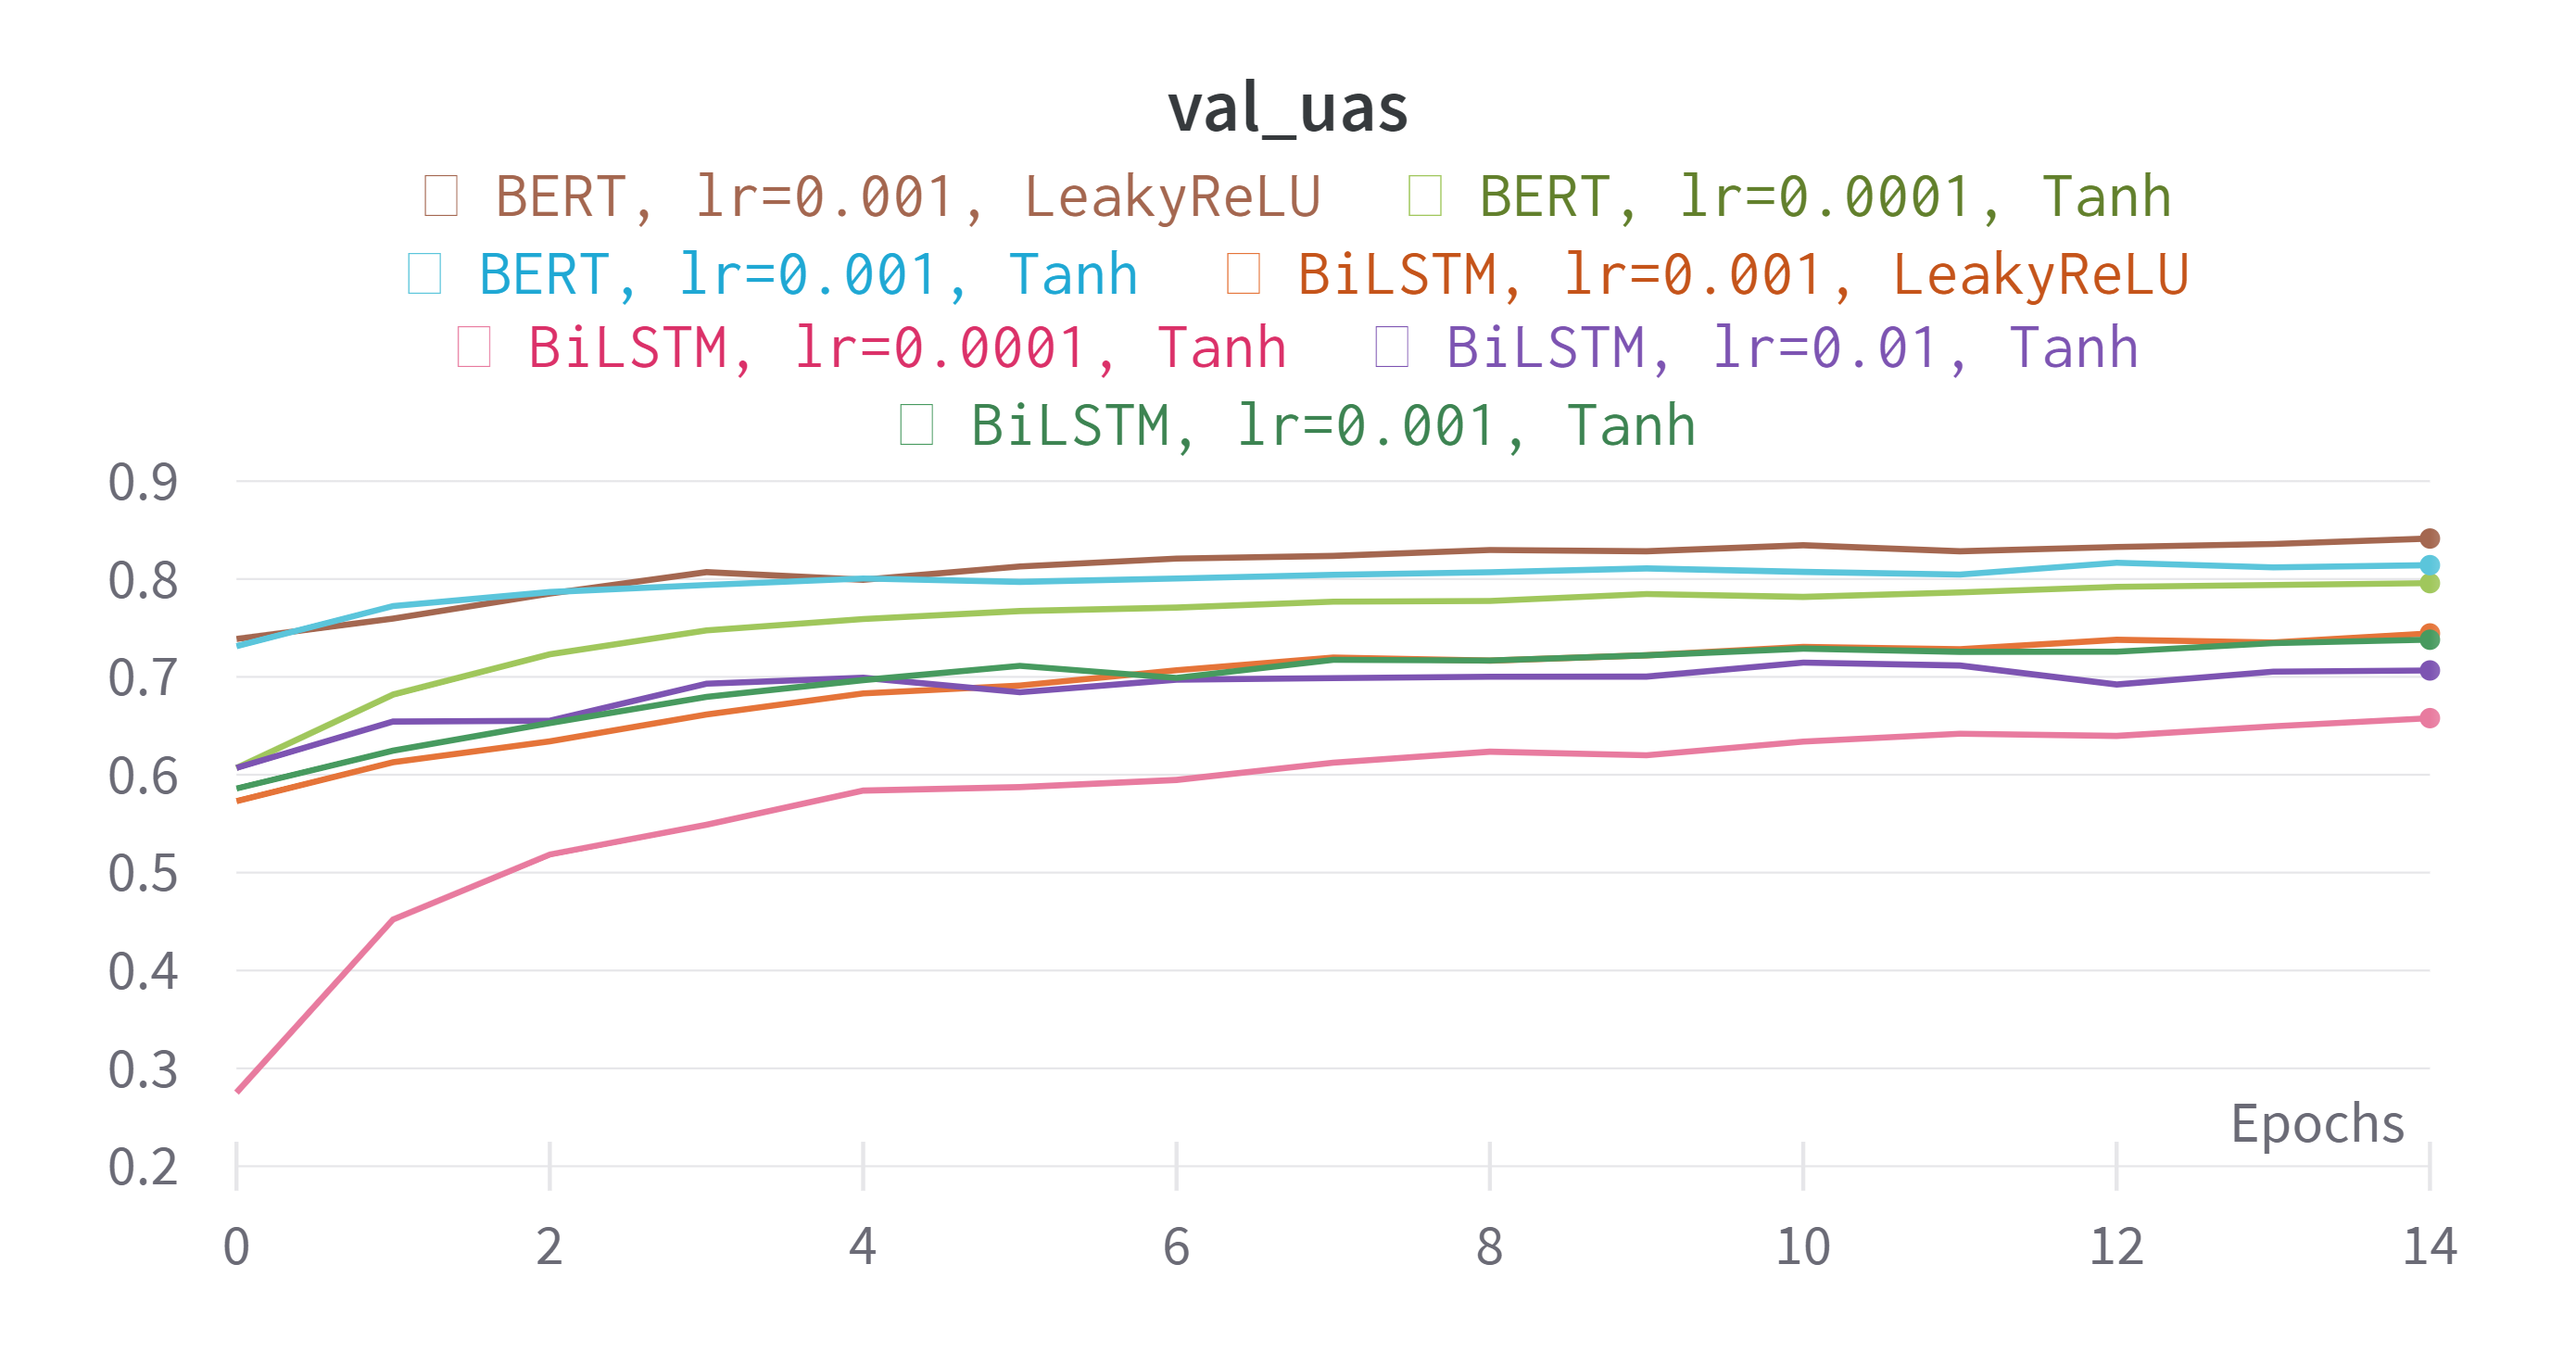

In [63]:
Image('image1.png')

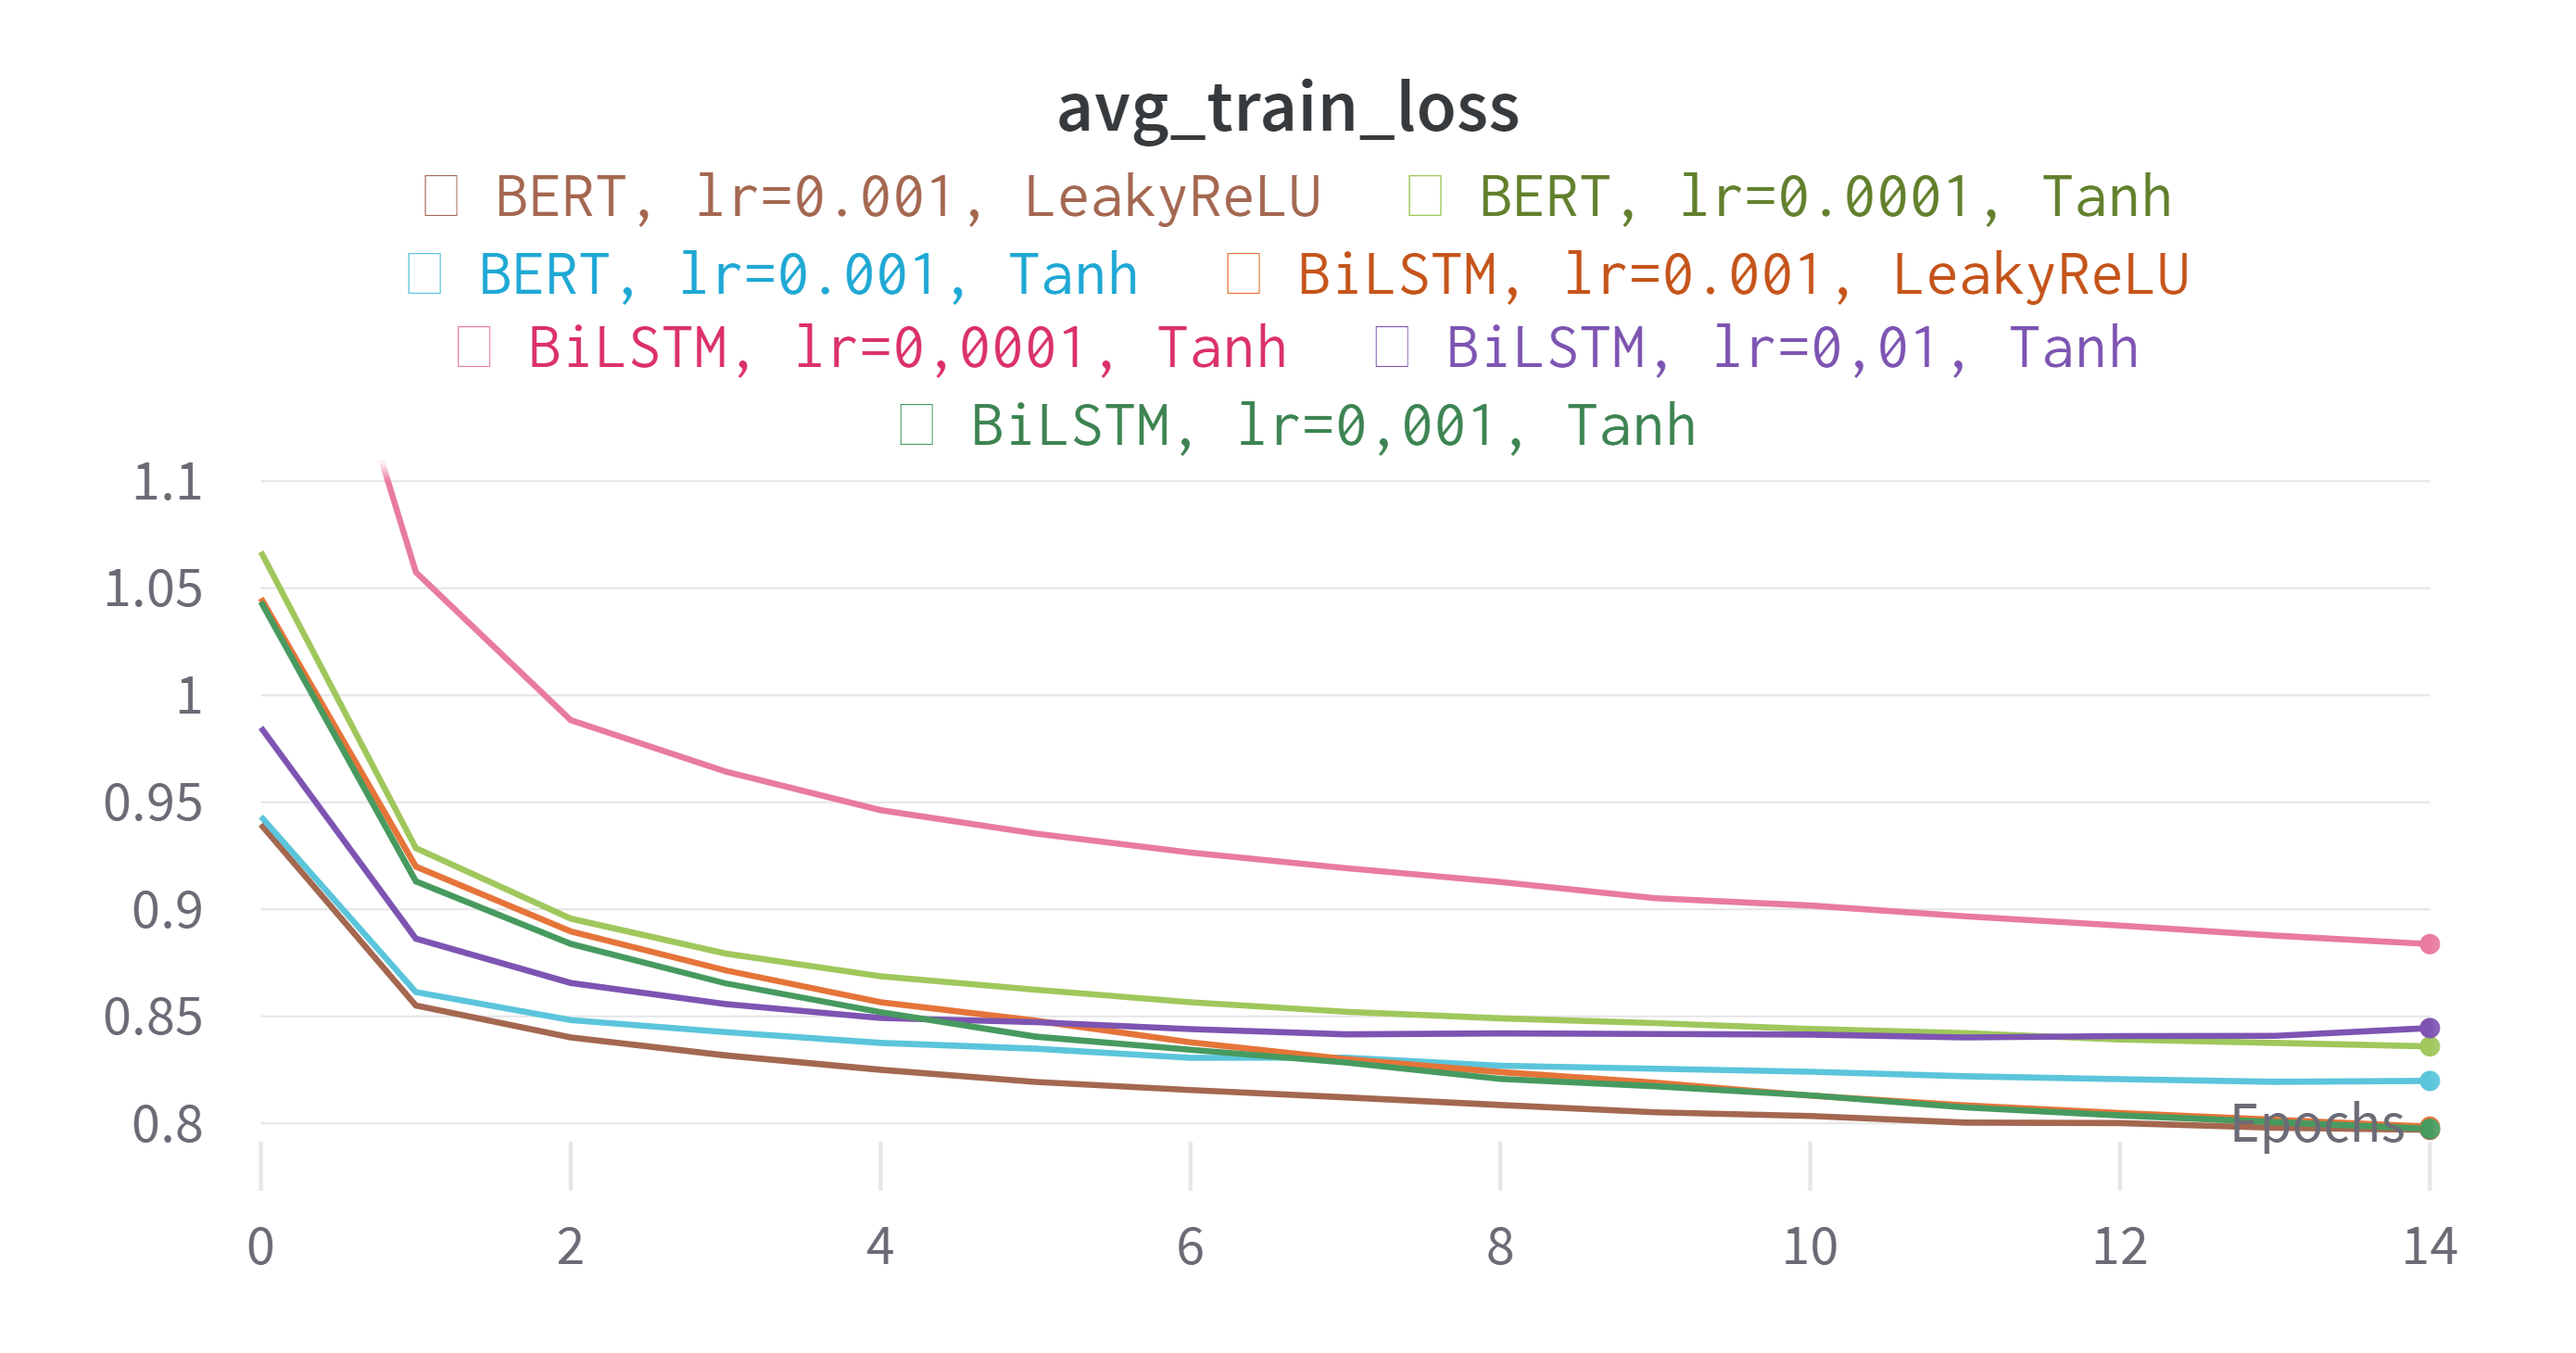

In [64]:
Image('image2.png')

We can notice that the BERT-based parser always outperform the BiLSTM. The best model is BERT with learning rate = 0.001 and LeakyReLU as activation function. The worst is BiLSTM with learning rate = 0.0001 and Tanh as activation function.

# Error Analysis

In this section we briefly view the errors computed from the BERT-based parser, in particular with respect to the number of wrong transitions.

In [41]:
print('Number of parsed trees:\t\t\t', len(test_dataset))
print("Number of wrongly parsed trees:\t\t", len(wrong_ind))
print("Number of wrongly parsed non-proj trees:", wrong_non_proj)

Number of parsed trees:			 1035
Number of wrongly parsed trees:		 660
Number of wrongly parsed non-proj trees: 67


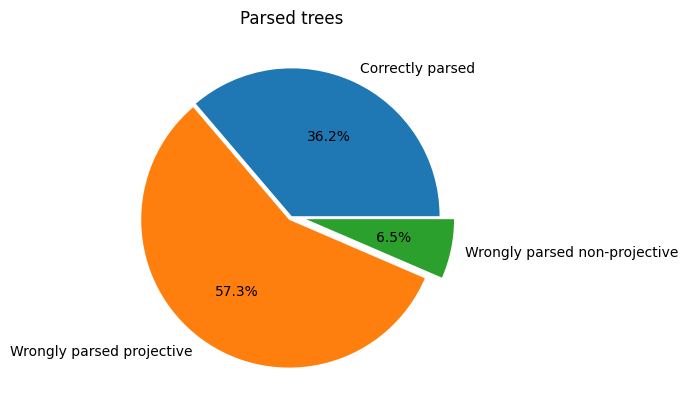

In [42]:
# pie chart for parsed trees
sizes = [len(test_dataset)-len(wrong_ind), len(wrong_ind)-wrong_non_proj, wrong_non_proj]
labels = 'Correctly parsed', 'Wrongly parsed projective', 'Wrongly parsed non-projective'

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0, 0.03, 0.1))
ax.set_title('Parsed trees')
fig.show()


Let's test now a dataset without non-projective sentences. In this way we can analyze the transitions that the parser mostly guess right or wrong without the bias of the non-projectivity.

In [43]:
test_dataset_non_proj = [ sample for sample in test_dataset if is_projective([int(head) for head in sample["head"]])]
test_dataloader_non_proj = torch.utils.data.DataLoader(test_dataset_non_proj, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch, get_gold_path=True))

print('Length of original test dataset:', len(test_dataset))
print('Length of new test dataset without non-projective samples:', len(test_dataset_non_proj))


Length of original test dataset: 1035
Length of new test dataset without non-projective samples: 968


In [44]:
(test_uas_np, wrong_non_proj_np, non_proj_np, wrong_ind_np), pred_moves_BERT_np = Bert_test(model, test_dataloader_non_proj)

In [50]:
# list of gold moves
gold_moves_flattened = []
for b in test_dataloader_non_proj:
  gold_moves_flattened = gold_moves_flattened + b[2]

# list of pred moves
pred_moves_BERT_flattened = []
for i in pred_moves_BERT_np:
  pred_moves_BERT_flattened = pred_moves_BERT_flattened + i

pred_moves_flattened = []
for m in pred_moves_BERT_flattened:
  pred_moves_flattened.append(m)

Text(0, 0.5, 'True Label')

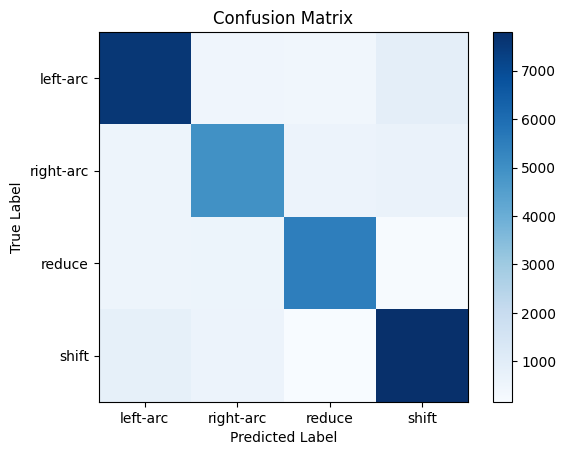

In [48]:
M = torch.zeros(4, 4)

for i, j in zip(gold_moves_flattened, pred_moves_flattened):
  min_length = min(len(i), len(j))
  M += confusion_matrix(i[0:min_length], j[0:min_length], labels=[0, 1, 2, 3])


class_labels = ['left-arc', 'right-arc', 'reduce', 'shift']

# Plot confusion matrix
plt.imshow(M, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=0)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [49]:
M = np.array(M)

num_labels = M.shape[0]

accuracy = np.zeros(num_labels)
precision = np.zeros(num_labels)
recall = np.zeros(num_labels)


for i in range(num_labels):
    TP = M[i, i]
    TN = np.sum(M) - (np.sum(M[i, :]) + np.sum(M[:, i]) - TP)
    FP = np.sum(M[:, i]) - TP
    FN = np.sum(M[i, :]) - TP

    accuracy[i] = (TP + TN) / (TP + TN + FP + FN)

    precision[i] = TP / (TP + FP)

    recall[i] = TP / (TP + FN)

for i in range(num_labels):
    print("Class:", class_labels[i])
    print("Accuracy: ", accuracy[i])
    print("Precision:", precision[i])
    print("Recall:   ", recall[i])

Class: left-arc
Accuracy:  0.8860421836228288
Precision: 0.8001055408970976
Recall:    0.8098493750667664
Class: right-arc
Accuracy:  0.8932382133995037
Precision: 0.752935793808144
Recall:    0.7304334960793016
Class: reduce
Accuracy:  0.9236352357320099
Precision: 0.8233258088788563
Recall:    0.8094392661636337
Class: shift
Accuracy:  0.8966501240694789
Precision: 0.8152253476942382
Recall:    0.8328170067300502


We can see that even if complessity it doesn't fully compute the correct dependencies, the BERT-based parser obtains still good result on predicting singular actions. `Reduce` as the highest accuracy (0.923) while `left_arc` is the 'worse' one with an accuracy of 0.886. Even if the squares are all pretty white, we can observe that the most freqents errors are between `left_arc` predicted as `shift` and the contrary as well ( `shift` transitions predicted as `left_arc`).

# SoTA

As regard the *State-of-The-Art* for unlabeled dependecy parsing in our dataset we refer to the **UDify** model. It is a multilingual multi-task Bert text encoder capable of accurately predicting universal part-of-speech morphological features, lemmas, and dependency trees simultaneously for all 124 Universal Dependencies treebanks across 75 languages. It has a UAS (Unlabeled Accuracy Score) of 87.33 [ [Parsing Universal Dependencies Universally](https://arxiv.org/pdf/1904.02099v3.pdf) ]

An other important model in the Leaderbord is **UDPipe** and its variants. In particular, *UDPipe 2.0 with WE+CLE+BERT+Flair where available* got a UA Score of 87.28. [[UDPipe 2.0 Prototype at CoNLL 2018 UD Shared Task](https://aclanthology.org/K18-2020.pdf)]


**LEADERBOARD**

|    | Model   | UAS   |
|---|---|---|
| 1 | UDify | 87.33   |
| 2 |  UDPipe 2.0 with WE+CLE+BERT+Flair where available | 87.28    |
| 3 |  UDPipe |   84.17  |